In [1]:
#https://medium.com/@craakash/applying-causal-inference-with-python-a-practical-guide-cf4878a9c5b2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from causalinference import CausalModel

np.random.seed(42)  # Seed for reproducibility
N = 500  # Number of observations
X1 = np.random.normal(0, 1, N)  # Confounder 1
X2 = np.random.normal(2, 1, N)  # Confounder 2
Z = 1 + 0.5 * X1 + 0.5 * X2 + np.random.normal(0, 0.1, N)  # Propensity score
D = (Z > 1.5).astype(int)  # Treatment assignment
Y = 2 + D * 2 + 1.5 * X1 + 0.5 * X2 + np.random.normal(0, 1, N)  # Outcome
df = pd.DataFrame({
    'Treatment': D,
    'Outcome': Y,
    'Confounder1': X1,
    'Confounder2': X2
})

c:\Users\User\anaconda3\Lib\site-packages\causalinference\estimators\ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]


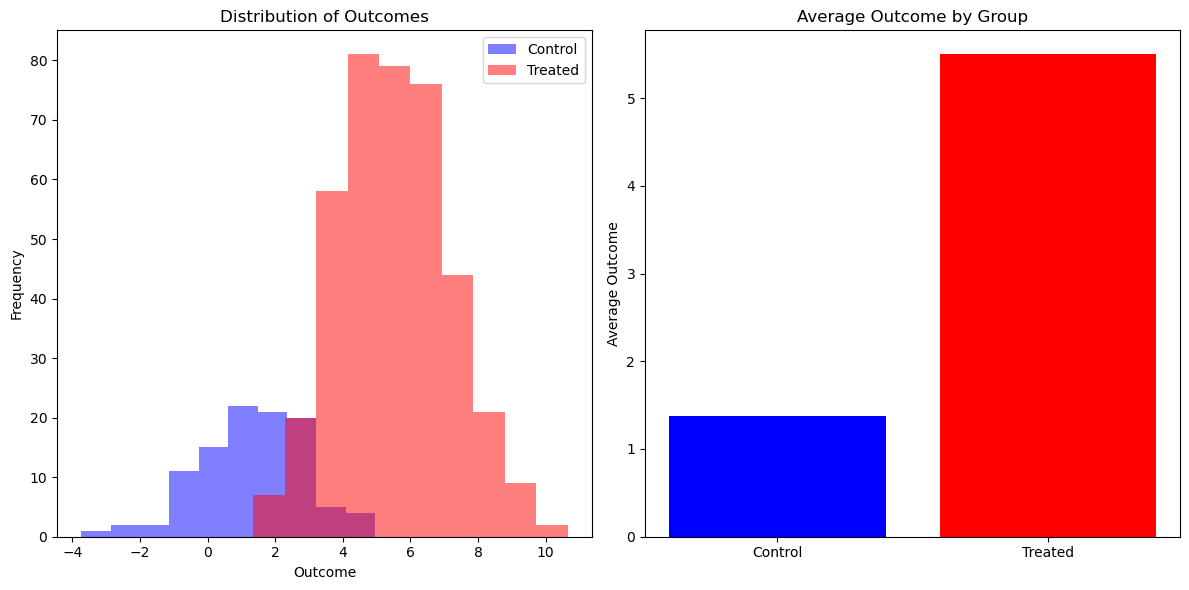

In [3]:
model = CausalModel(
    Y=df['Outcome'].values,
    D=df['Treatment'].values,
    X=df[['Confounder1', 'Confounder2']].values
)

model.est_via_ols()
model.est_via_matching()

# Visualizing the outcomes
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df[df['Treatment'] == 0]['Outcome'], alpha=0.5, label='Control', color='blue')
plt.hist(df[df['Treatment'] == 1]['Outcome'], alpha=0.5, label='Treated', color='red')
plt.title('Distribution of Outcomes')
plt.xlabel('Outcome')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
treated_mean = df[df['Treatment'] == 1]['Outcome'].mean()
control_mean = df[df['Treatment'] == 0]['Outcome'].mean()
plt.bar(['Control', 'Treated'], [control_mean, treated_mean], color=['blue', 'red'])
plt.title('Average Outcome by Group')
plt.ylabel('Average Outcome')

plt.tight_layout()
plt.show()

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import dowhy
from dowhy import CausalModel
import dowhy.datasets

#import warnings
#warnings.filterwarnings('ignore')

,X0,Z0,Z1,W0,W1,v0,y
0,0.223181,1.0,0.654103,0.843142,0.093900,True,11.548587
1,-0.331373,1.0,0.069626,-0.814563,0.967354,True,7.666159
2,0.920007,1.0,0.285215,-1.636306,0.561903,True,5.437021
3,1.461500,1.0,0.682695,-0.848274,-1.194887,True,3.583524
4,1.251174,1.0,0.539622,0.170275,1.160336,True,14.046308


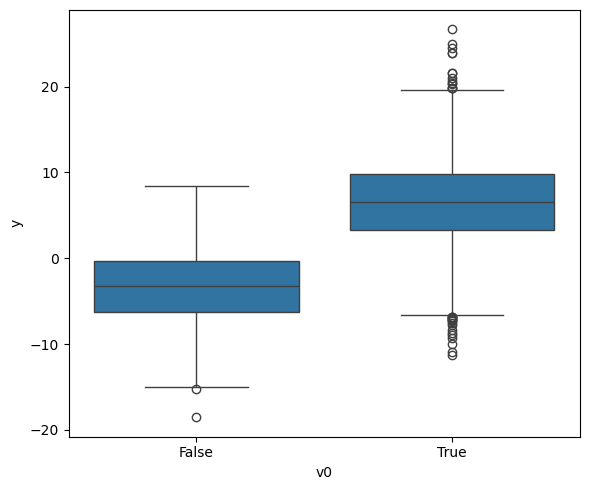

In [78]:


BETA = 8
np.random.seed(7)
data = dowhy.datasets.linear_dataset(BETA,
                                    num_common_causes=2, # confounders
                                    num_samples=5000,
                                    num_instruments=2, # instrument variables
                                    num_effect_modifiers=1, # features
                                    treatment_is_binary=True,
                                    stddev_treatment_noise=5,
                                    num_treatments=1)

df = data['df']
display(df.head())

plt.figure(figsize=(6,5))
sns.boxplot(y='y', x='v0', data=df)
plt.tight_layout()
plt.show()

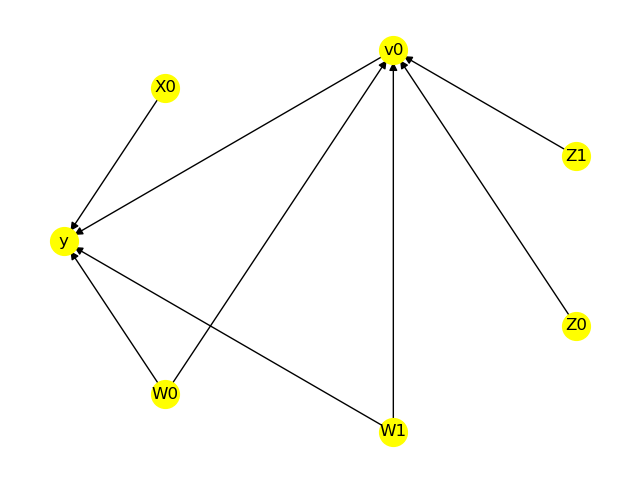

In [79]:
model = CausalModel(data=data['df'],
                   treatment=data['treatment_name'],
                   outcome=data['outcome_name'],
                   graph=data['gml_graph'])

model.view_model()

In [80]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)

print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d              
─────(E[y|W1,W0])
d[v₀]            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,U) = P(y|v0,W1,W0)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [81]:
causal_estimate = model.estimate_effect(
    identified_estimand,
    method_name="iv.instrumental_variable")

print(causal_estimate.value)

instrumental_variable
                          IV2SLS Regression Results                           
Dep. Variable:                      y   R-squared:                       0.629
Model:                         IV2SLS   Adj. R-squared:                  0.629
Method:                     Two Stage   F-statistic:                       nan
                        Least Squares   Prob (F-statistic):                nan
Date:                Fri, 31 Jan 2025                                         
Time:                        22:50:49                                         
No. Observations:                5000                                         
Df Residuals:                    4999                                         
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
v0             6.4973      0.0

In [82]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

dml_estimate = model.estimate_effect(
    identified_estimand, 
    method_name="iv.econml.dml.DML",
    control_value = 0,
    treatment_value = 1,
    confidence_intervals=False,
    method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                  'model_t': GradientBoostingRegressor(),
                                  "model_final":LassoCV(fit_intercept=False),
                                  'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                   "fit_params":{}})
print(dml_estimate.value)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


7.587029577531776
